Download historical data from EIA and NOAA/GHCN-d to the local filesystem

In [1]:
import download_historical_data as dl
import os 
import matplotlib.pyplot as plt
import pandas as pd

HISTORICAL_DATA_DIR = os.path.abspath("./historical_data")
ELECTRIC_DATA_DIR = os.path.join(HISTORICAL_DATA_DIR, "electric_data")
WEATHER_DATA_DIR = os.path.join(HISTORICAL_DATA_DIR, "weather_station_data")
WEATHER_STATION_IDS = [
    "USW00023066",  # Grand Junction Walker Field
    "USC00053553",  # Greeley UNC
    "USC00053005",  # Ft Collins
    "USC00050848",  # Boulder
    "USC00055984",  # Northglenn
    "USC00058995",  # Wheat Ridge
    "USW00023061"  # Alamosa
]

# Uncomment to force re-download of source data
# Otherwise can also run the download script manually via: python download_historical_data.py
# Data files are saved locally so you only need to re-download to get new/different data
#dl.download_eia_historical_data(ELECTRIC_DATA_DIR, eia_respondent="PSCO")
#dl.download_ghcnd_historical_data(WEATHER_DATA_DIR, WEATHER_STATION_IDS)

Reading dataframe for station USC00050848
Reading dataframe for station USC00053005
Reading dataframe for station USC00053553
Reading dataframe for station USC00055984
Reading dataframe for station USC00058995
Reading dataframe for station USW00023061
Reading dataframe for station USW00023066
       USC00050848_tmax  USC00050848_tmin  USC00053005_tmax  USC00053005_tmin  \
count       2821.000000       2821.000000       2852.000000       2852.000000   
mean          19.674016          3.629156         18.934204          3.210589   
std           10.182651          8.498788         10.450839          8.989992   
min          -15.600000        -24.400000        -16.700000        -26.700000   
25%           12.200000         -2.800000         11.100000         -3.450000   
50%           20.600000          3.900000         19.400000          3.300000   
75%           28.300000         11.100000         27.800000         11.700000   
max           37.800000         22.200000         38.30000

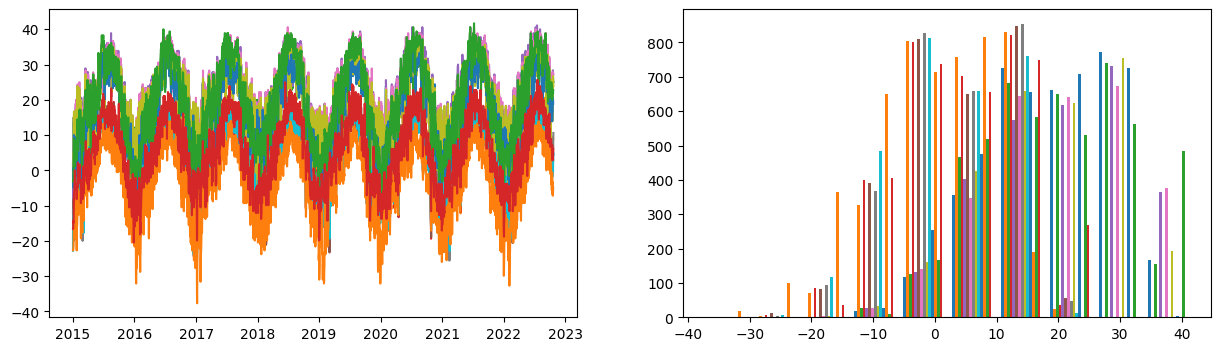

In [2]:
import glob

plt.style.use("default") #alternative "ggplot"

temp_df : pd.DataFrame = None

## Load up temperature data for each weather station, into their own columns
for df_file in glob.glob(WEATHER_DATA_DIR + "\*.json"):
    with open(df_file, "r", encoding="utf-8") as f:
        station_id = os.path.basename(df_file)[0:11]
        print(f"Reading dataframe for station {station_id}")
        station_df = pd.read_json(f)
        station_df.index.rename("date", inplace=True)
        
        # TODO: This name-mangling seems like a halfassed way to either do a MultiIndex or maybe a tuple-index
        # Going to leave it for now as I'm not clear what will be easiest when trying to train an ML model
        col_renames = {col: f"{station_id}_{col}" for col in station_df.columns}
        station_df.rename(col_renames, axis="columns", inplace=True)
        
        if temp_df is not None:
            temp_df = pd.merge(left=temp_df, right=station_df, how="outer", left_index=True, right_index=True)
        else:
            temp_df = station_df

station_df["tmp_date"] = station_df.index
station_df["day_of_year"] = station_df["tmp_date"].dt.day_of_year
station_df.drop("tmp_date", axis=1, inplace=True)

print(temp_df.describe())

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(4)
ax1.plot(temp_df)
_ = ax2.hist(temp_df, bins=10)


Load electric demand data

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

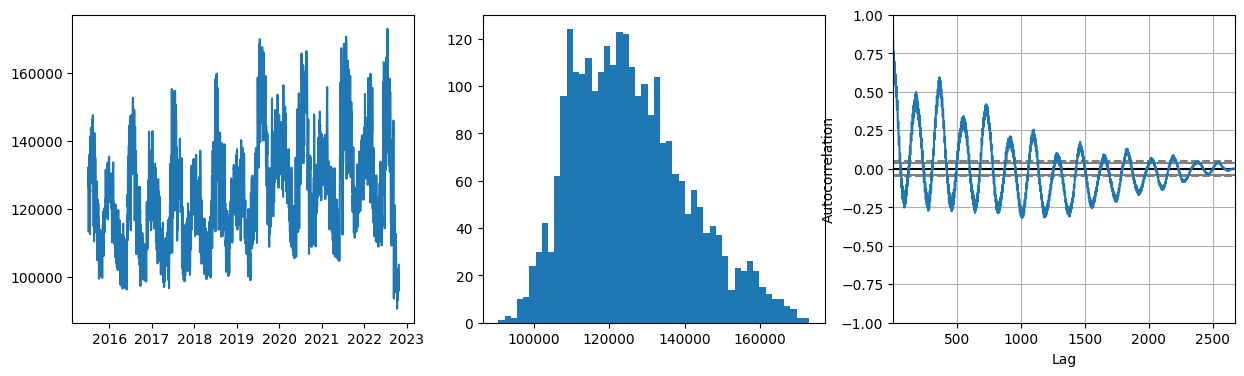

In [3]:
psco_demand_data_file = os.path.join(ELECTRIC_DATA_DIR, "psco-daily-dataframe.json")
with open(psco_demand_data_file, "r", encoding="utf-8") as f:
    demand_df = pd.read_json(f)

demand_df.index.rename("date", inplace=True)

##demand_df["daily_demand"].plot(style=".")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(4)
ax1.plot(demand_df)
ax2.hist(demand_df, bins=50)
pd.plotting.autocorrelation_plot(demand_df)

In [4]:
joined_df = pd.merge(demand_df, temp_df, how="outer", left_index=True, right_index=True)
joined_df.dropna(inplace=True)

# slice = joined_df[["daily_demand", "tmax", "tmin"]]  #["2016-12-01":"2017-03-01"]

# fig, ax1 = plt.subplots(1, 1)
# fig.set_figwidth(15)
# fig.set_figheight(4)
# ax1.set_ylabel("megawatt-hours")
# ax1.plot(slice["daily_demand"], color="tab:green")

# ax2 = ax1.twinx()
# ax2.set_ylabel("deg C")
# ax2.plot(slice["tmax"], color="tab:red")
# ax2.plot(slice["tmin"], color="tab:blue")


In [5]:
joined_df.corr()

,daily_demand,USC00050848_tmax,USC00050848_tmin,USC00053005_tmax,USC00053005_tmin,USC00053553_tmax,USC00053553_tmin,USC00055984_tmax,USC00055984_tmin,USC00058995_tmax,USC00058995_tmin,USW00023061_tmax,USW00023061_tmin,USW00023066_tmax,USW00023066_tmin
daily_demand,1.000000,0.197963,0.192565,0.191557,0.198092,0.172717,0.213958,0.207758,0.206283,0.192160,0.210744,0.157422,0.157892,0.198359,0.229364
USC00050848_tmax,0.197963,1.000000,0.901859,0.979215,0.869748,0.966510,0.876136,0.896411,0.883491,0.902945,0.861941,0.884527,0.770869,0.888960,0.844236
USC00050848_tmin,0.192565,0.901859,1.000000,0.905876,0.965382,0.908533,0.957538,0.911027,0.958184,0.915725,0.944812,0.871586,0.844220,0.876085,0.887633
USC00053005_tmax,0.191557,0.979215,0.905876,1.000000,0.882126,0.971225,0.888886,0.879998,0.891727,0.883590,0.871201,0.885508,0.782589,0.899075,0.854138
USC00053005_tmin,0.198092,0.869748,0.965382,0.882126,1.000000,0.894247,0.982164,0.897911,0.964252,0.899138,0.964997,0.882396,0.888728,0.895394,0.916678
USC00053553_tmax,0.172717,0.966510,0.908533,0.971225,0.894247,1.000000,0.903075,0.909232,0.901842,0.912097,0.886155,0.898257,0.807488,0.903377,0.864820
USC00053553_tmin,0.213958,0.876136,0.957538,0.888886,0.982164,0.903075,1.000000,0.896050,0.960294,0.896840,0.961198,0.887153,0.884678,0.901035,0.916623
USC00055984_tmax,0.207758,0.896411,0.911027,0.879998,0.897911,0.909232,0.896050,1.000000,0.906481,0.980606,0.894377,0.855798,0.794866,0.846383,0.843724
USC00055984_tmin,0.206283,0.883491,0.958184,0.891727,0.964252,0.901842,0.960294,0.906481,1.000000,0.903765,0.975722,0.880229,0.874517,0.894933,0.909729
USC00058995_tmax,0.192160,0.902945,0.915725,0.883590,0.899138,0.912097,0.896840,0.980606,0.903765,1.000000,0.893638,0.856255,0.791327,0.846780,0.840019
